In [1]:
# Import required modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Create the directory structure
!mkdir -p /content/coco/annotations /content/coco/val2017

# Download annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -P /content/coco/

# Download validation images (val2017)
!wget http://images.cocodataset.org/zips/val2017.zip -P /content/coco/

# Extract the downloaded files
!unzip -q /content/coco/annotations_trainval2017.zip -d /content/coco/annotations/
!unzip -q /content/coco/val2017.zip -d /content/coco/


--2025-01-25 13:40:58--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.13.130, 52.216.138.12, 16.182.37.113, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.13.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/coco/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  31.8MB/s    in 8.0s    

2025-01-25 13:41:06 (30.1 MB/s) - ‘/content/coco/annotations_trainval2017.zip’ saved [252907541/252907541]

--2025-01-25 13:41:07--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.76.76, 3.5.27.189, 16.182.37.249, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.76.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!
Loaded 5000 samples from COCO.
Sample Image Shape: torch.Size([3, 64, 64])
Annotation: [{'segmentation': [[240.86, 211.31, 240.16, 197.19, 236.98, 192.26, 237.34, 187.67, 245.8, 188.02, 243.33, 176.02, 250.39, 186.96, 251.8, 166.85, 255.33, 142.51, 253.21, 190.49, 261.68, 183.08, 258.86, 191.2, 260.98, 206.37, 254.63, 199.66, 252.51, 201.78, 251.8, 212.01]], 'area': 531.8071000000001, 'iscrowd': 0, 'image_id': 139, 'bbox': [236.98, 142.51, 24.7, 69.5], 'category_id': 64, 'id': 26547}, {'segmentation': [[9.66, 167.76, 156.35, 173.04, 153.71, 256.48, 82.56, 262.63, 7.03, 260.87]], 'area': 13244.657700000002, 'iscrowd': 0, 'image_id': 139, 'bbox': [7.03, 167.76, 149.32, 94.87], 'category_id': 72, 'id': 34646}, {'segmentation': [[563.33, 209.19, 637.69, 209.19, 638.56, 287.92, 557.21, 280.04]], 'area': 5833.117949999999, 'iscrowd': 0, 'image_id': 139, 'bbox': [557.21, 209.19, 81.35, 78.73], 'category_id': 72

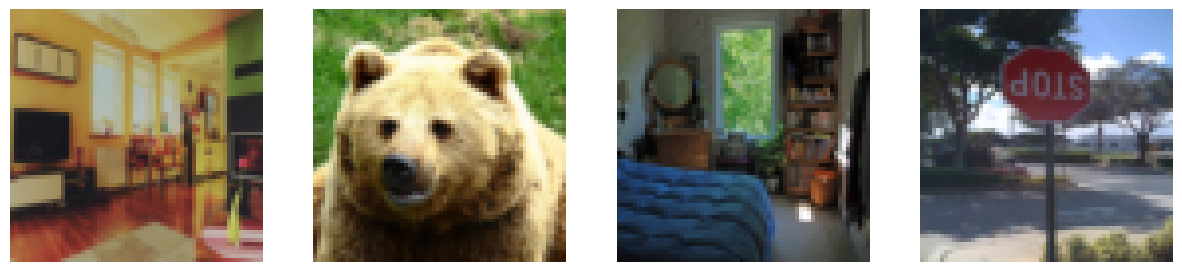

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import os

# Set COCO dataset path
coco_path = "/content/coco"

# Install pycocotools
!pip install pycocotools

# Create a preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),       # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize between -1 and 1
])

# Load COCO dataset (validation set as an example)
coco_dataset = CocoDetection(root=os.path.join(coco_path, 'val2017'),
                             annFile=os.path.join(coco_path, 'annotations/annotations/instances_val2017.json'),
                             transform=transform)


# Display Information
print(f"Loaded {len(coco_dataset)} samples from COCO.")

# Validate Dataset
img, ann = coco_dataset[0]  # Load first image and annotation
print(f"Sample Image Shape: {img.shape}")
print(f"Annotation: {ann}")

# DataLoader
coco_loader = DataLoader(coco_dataset, batch_size=4, shuffle=True)

# De-normalization function
def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)  # Shape (C, H, W)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    tensor = tensor * std + mean  # Reverse the normalization
    return torch.clamp(tensor, 0, 1)  # Clamp to ensure values are within [0, 1]

# Display a Few Images
def show_images(dataset, num_images=4):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, _ = dataset[i]  # Properly index the dataset
        img = denormalize(img)  # De-normalize the image
        ax[i].imshow(to_pil_image(img))
        ax[i].axis("off")
    plt.show()

show_images(coco_dataset, num_images=4)


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downsample by 2
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(128 * 8 * 8, latent_dim)  # Map to latent space

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 128 * 8 * 8)  # Map back to encoded tensor
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample by 2
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample by 2
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample by 2
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        enc = self.encoder(x)
        latent = self.fc_enc(self.flatten(enc))

        # Decoder
        dec = self.fc_dec(latent).view(-1, 128, 8, 8)
        dec = self.decoder(dec)
        return dec, latent
model = ConvAutoencoder(latent_dim=16).to(device)


In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim  # Import optim

# Custom collate function to handle variable-sized annotations
def custom_collate(batch):
    images = torch.stack([item[0] for item in batch])
    return images

# Modified DataLoader with custom collate function
coco_loader = DataLoader(
    coco_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=custom_collate
)

# Modify training loop to handle the new batch format
# Directory to save models in Colab
model_save_path = "/content/saved_models"
os.makedirs(model_save_path, exist_ok=True)  # Create directory if it doesn't exist

def train_model(model, dataloader, epochs):
    model.train()  # Ensure model is in training mode
    model = model.to(device)  # Move model to device
    criterion = nn.MSELoss()  # Loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjusted learning rate

    latest_model_path = os.path.join(model_save_path, "latest_autoencoder.pth")  # Save only the latest

    for epoch in range(epochs):
        total_loss = 0
        for images in dataloader:  # No labels in the dataloader
            images = images.to(device)  # Move images to device

            # Add noise for denoising task
            noise = torch.randn_like(images) * 0.1
            noisy_images = images + noise
            noisy_images = torch.clamp(noisy_images, -1, 1)

            # Forward pass
            outputs = model(noisy_images)
            loss = criterion(outputs, images)

            # Backward pass
            optimizer.zero_grad()  # Clear accumulated gradients
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss}")

        # Save the model only every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), latest_model_path)
            print(f"Model saved for epoch {epoch + 1} at {latest_model_path}")

# Now you can train the model
#train_model(model, coco_loader, epochs=100)



In [16]:
# Show reconstructed and noisy images
def visualize_reconstruction(model, dataloader, num_images=4):
    model.eval()
    dataiter = iter(dataloader)
    images = next(dataiter)
    images = images[:num_images]  # Now, this slice will be within bounds
    noisy_images = images + torch.randn_like(images) * 0.1
    noisy_images = torch.clamp(noisy_images, -1, 1)


    # Predict
    with torch.no_grad():
        noisy_images = noisy_images.to(device)
        recon_images = model(noisy_images)
        recon_images = recon_images.cpu()

    # De-normalize
    noisy_images = noisy_images.cpu()
    # De-normalize
    images = (images * 0.5) + 0.5
    noisy_images = (noisy_images * 0.5) + 0.5
    recon_images = (recon_images * 0.5) + 0.5

    # Plot
    fig, axes = plt.subplots(3, num_images, figsize=(15, 6))
    for i in range(num_images):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(noisy_images[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[2, i].imshow(recon_images[i].permute(1, 2, 0))
        axes[2, i].axis('off')
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Noisy')
    axes[2, 0].set_ylabel('Reconstructed')
    plt.show()

# Visualize results
#visualize_reconstruction(model, coco_loader)


In [ ]:
# Evaluation Metrics Calculation
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Ensure necessary libraries are installed
!pip install scikit-image -q  # Install scikit-image quietly

def evaluate_model(model, dataloader):
    model.eval()
    total_mse = 0
    total_psnr = 0
    total_ssim = 0

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            noisy_images = images + torch.randn_like(images) * 0.1
            noisy_images = torch.clamp(noisy_images, -1, 1)

            # Create dummy labels (all zeros)
            dummy_labels = torch.zeros(images.shape[0], dtype=torch.int64, device=device)

            outputs, _ = model(noisy_images)

            # Calculate MSE
            batch_mse = mean_squared_error(images.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
            total_mse += batch_mse

            # Calculate PSNR
            batch_psnr = psnr(images.cpu().numpy(), outputs.cpu().numpy(), data_range=1.0)
            total_psnr += batch_psnr


            # Adjust win_size based on actual image size
            image_shape = images.shape
            win_size = min(image_shape[2], image_shape[3])

            # Ensure win_size is odd and less than or equal to the smaller side
            win_size = win_size // 2 * 2 + 1  # Make win_size odd
            win_size = min(win_size, image_shape[2], image_shape[3])  # Limit win_size
            win_size = max(win_size, 7) # Ensure minimum win_size of 7 for SSIM



    avg_mse = total_mse / len(dataloader)
    avg_psnr = total_psnr / len(dataloader)


    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")

# Call the evaluation function
evaluate_model(model, coco_loader)

Average MSE: 0.0895
Average PSNR: 10.5966


In [ ]:
model_2 = ConvAutoencoder(latent_dim=128).to(device)

In [ ]:
# Directory to save models in Colab
model_save_path = "/content/saved_models"
os.makedirs(model_save_path, exist_ok=True)  # Create directory if it doesn't exist

# Now you can train the model
train_model(model_2, coco_loader, epochs=60)



Epoch [1/60], Loss: 0.29116761978644473
Epoch [2/60], Loss: 0.13467797822063896
Epoch [3/60], Loss: 0.10657080277136177
Epoch [4/60], Loss: 0.09328378485456394
Epoch [5/60], Loss: 0.0849911325676426
Epoch [6/60], Loss: 0.07785970931220207
Epoch [7/60], Loss: 0.07102216203596182
Epoch [8/60], Loss: 0.0662424882079006
Epoch [9/60], Loss: 0.06299438439072318
Epoch [10/60], Loss: 0.060232892893492034
Model saved for epoch 10 at /content/saved_models/latest_autoencoder.pth
Epoch [11/60], Loss: 0.057568803477059505
Epoch [12/60], Loss: 0.05554222737907604
Epoch [13/60], Loss: 0.053700414741305026
Epoch [14/60], Loss: 0.05194866571836411
Epoch [15/60], Loss: 0.05119303912873481
Epoch [16/60], Loss: 0.049814267143322405
Epoch [17/60], Loss: 0.04917677394618654
Epoch [18/60], Loss: 0.048395243823338464
Epoch [19/60], Loss: 0.04762115766098545
Epoch [20/60], Loss: 0.046874317393940726
Model saved for epoch 20 at /content/saved_models/latest_autoencoder.pth
Epoch [21/60], Loss: 0.0467449766198161

KeyboardInterrupt: 

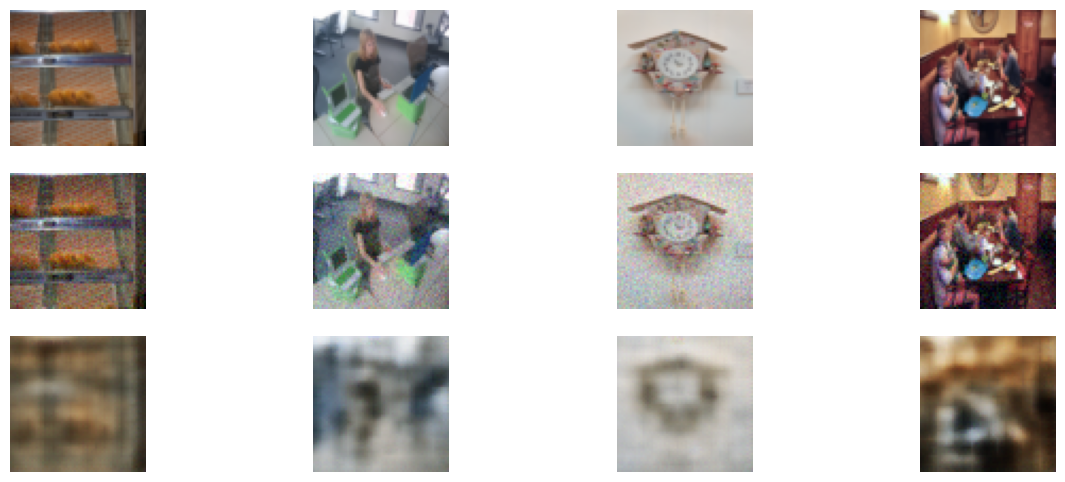

In [ ]:
# Visualize results
visualize_reconstruction(model, coco_loader)

In [ ]:
evaluate_model(model_2, coco_loader)

NameError: name 'evaluate_model' is not defined

In [ ]:
model_3 = ConvAutoencoder(latent_dim=512).to(device)

In [ ]:
# Directory to save models in Colab
model_save_path = "/content/saved_models"
os.makedirs(model_save_path, exist_ok=True)  # Create directory if it doesn't exist

# Now you can train the model
train_model(model_3, coco_loader, epochs=60)


In [ ]:
evaluate_model(model_3, coco_loader)

In [6]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # 64x64 -> 64x64
            nn.Tanh(),
            nn.MaxPool2d(2, return_indices=True),  # 64x64 -> 32x32
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.Tanh(),
            nn.MaxPool2d(2, return_indices=True),  # 32x32 -> 16x16
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 16x16 -> 16x16
            nn.Tanh(),
            nn.MaxPool2d(2, return_indices=True)   # 16x16 -> 8x8
        )

        # Decoder
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2)  # 8x8 -> 16x16
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),  # 16x16 -> 16x16
            nn.Tanh()
        )
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2)  # 16x16 -> 32x32
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.Tanh()
        )
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2)  # 32x32 -> 64x64
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),  # 64x64 -> 64x64
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder
        x1, indices1 = self.encoder[0:3](x)  # First conv + max pool
        x2, indices2 = self.encoder[3:6](x1)  # Second conv + max pool
        x3, indices3 = self.encoder[6:9](x2)  # Third conv + max pool

        # Decoder
        x3 = self.unpool1(x3, indices3)  # Unpool back to 16x16
        x3 = self.decoder1(x3)

        x2 = self.unpool2(x3, indices2)  # Unpool back to 32x32
        x2 = self.decoder2(x2)

        x1 = self.unpool3(x2, indices1)  # Unpool back to 64x64
        x1 = self.decoder3(x1)

        return x1



In [7]:
model_4 = ConvAutoencoder().to(device)

In [13]:
# Directory to save models in Colab
model_save_path = "/content/saved_models"
os.makedirs(model_save_path, exist_ok=True)  # Create directory if it doesn't exist

# Now you can train the model
train_model(model_4, coco_loader, epochs=60)


Epoch [1/60], Loss: 0.0874195032864809
Epoch [2/60], Loss: 0.03548276623785496
Epoch [3/60], Loss: 0.026571416468918325
Epoch [4/60], Loss: 0.022479197520017626
Epoch [5/60], Loss: 0.019656401707232
Epoch [6/60], Loss: 0.017558505208045243
Epoch [7/60], Loss: 0.016538189700990916
Epoch [8/60], Loss: 0.015828927566111088
Epoch [9/60], Loss: 0.01529591563306749
Epoch [10/60], Loss: 0.014877600098401307
Model saved for epoch 10 at /content/saved_models/latest_autoencoder.pth
Epoch [11/60], Loss: 0.014520058737695216
Epoch [12/60], Loss: 0.014240437194705009
Epoch [13/60], Loss: 0.013980810587108134
Epoch [14/60], Loss: 0.01376127639003098
Epoch [15/60], Loss: 0.013566726656258106
Epoch [16/60], Loss: 0.013395030178874731
Epoch [17/60], Loss: 0.01325280189961195
Epoch [18/60], Loss: 0.013094394529983401
Epoch [19/60], Loss: 0.012970555929839611
Epoch [20/60], Loss: 0.012860647868737578
Model saved for epoch 20 at /content/saved_models/latest_autoencoder.pth
Epoch [21/60], Loss: 0.012745008

KeyboardInterrupt: 

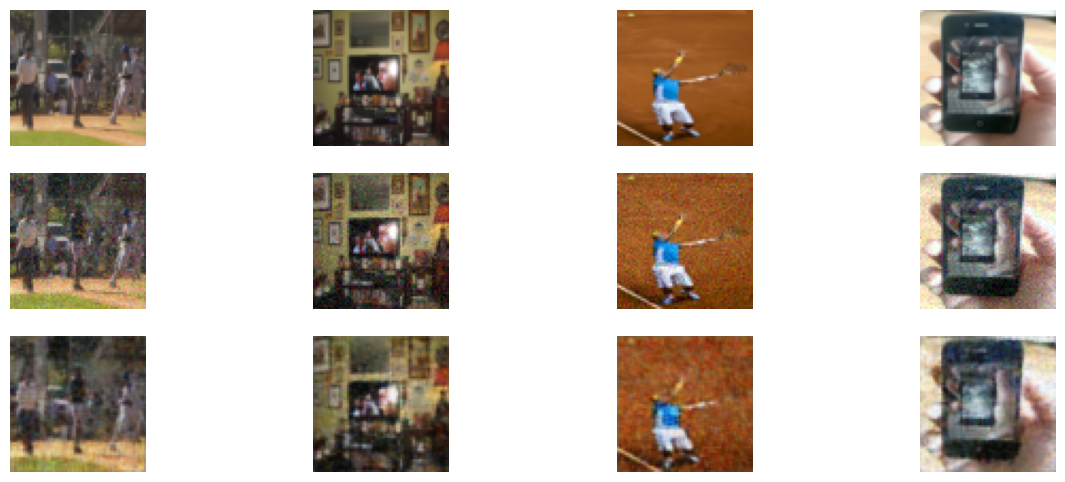

In [17]:
# Visualize results
visualize_reconstruction(model_4, coco_loader)

In [19]:
# Evaluation Metrics Calculation
from sklearn.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Ensure necessary libraries are installed
!pip install scikit-image -q  # Install scikit-image quietly

def evaluate_model(model, dataloader):
    model.eval()
    total_mse = 0
    total_psnr = 0
    total_ssim = 0

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            noisy_images = images + torch.randn_like(images) * 0.1
            noisy_images = torch.clamp(noisy_images, -1, 1)

            # Create dummy labels (all zeros)
            dummy_labels = torch.zeros(images.shape[0], dtype=torch.int64, device=device)

            outputs = model(noisy_images)

            # Calculate MSE
            batch_mse = mean_squared_error(images.cpu().numpy().flatten(), outputs.cpu().numpy().flatten())
            total_mse += batch_mse

            # Calculate PSNR
            batch_psnr = psnr(images.cpu().numpy(), outputs.cpu().numpy(), data_range=1.0)
            total_psnr += batch_psnr


            # Adjust win_size based on actual image size
            image_shape = images.shape
            win_size = min(image_shape[2], image_shape[3])

            # Ensure win_size is odd and less than or equal to the smaller side
            win_size = win_size // 2 * 2 + 1  # Make win_size odd
            win_size = min(win_size, image_shape[2], image_shape[3])  # Limit win_size
            win_size = max(win_size, 7) # Ensure minimum win_size of 7 for SSIM



    avg_mse = total_mse / len(dataloader)
    avg_psnr = total_psnr / len(dataloader)


    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")

# Call the evaluation function
evaluate_model(model_4, coco_loader)

Average MSE: 0.0113
Average PSNR: 19.5258


In [20]:
import torch.nn as nn
import torch

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 64x64 -> 32x32
            nn.Tanh()
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.Tanh()
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.Tanh()
        )

        # Decoder
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.Tanh()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.Tanh()
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self, x):
        # Encoder with skip connections
        enc1 = self.encoder1(x)  # Output: 32x32
        enc2 = self.encoder2(enc1)  # Output: 16x16
        enc3 = self.encoder3(enc2)  # Output: 8x8

        # Decoder with skip connections
        dec = self.decoder1(enc3 + enc3)  # Combine enc3 with itself for symmetry
        dec = self.decoder2(dec + enc2)  # Combine with enc2
        dec = self.decoder3(dec + enc1)  # Combine with enc1
        return dec


In [21]:
model_5 = ConvAutoencoder().to(device)

# Directory to save models in Colab
model_save_path = "/content/saved_models"
os.makedirs(model_save_path, exist_ok=True)  # Create directory if it doesn't exist

# Now you can train the model
train_model(model_5, coco_loader, epochs=60)

Epoch [1/60], Loss: 0.031975117746740576
Epoch [2/60], Loss: 0.009224527674913406
Epoch [3/60], Loss: 0.006806816925108433
Epoch [4/60], Loss: 0.00574954675808549
Epoch [5/60], Loss: 0.005166468339785933
Epoch [6/60], Loss: 0.0048290208440274
Epoch [7/60], Loss: 0.004600022994913161
Epoch [8/60], Loss: 0.004444857360236347
Epoch [9/60], Loss: 0.004318825803697109
Epoch [10/60], Loss: 0.004218998468853533
Model saved for epoch 10 at /content/saved_models/latest_autoencoder.pth
Epoch [11/60], Loss: 0.004138485722802579
Epoch [12/60], Loss: 0.0040668073702603575
Epoch [13/60], Loss: 0.004011778883263469
Epoch [14/60], Loss: 0.0039518256995826955
Epoch [15/60], Loss: 0.003908126747794449
Epoch [16/60], Loss: 0.0038701128114014866
Epoch [17/60], Loss: 0.0038299177883192896
Epoch [18/60], Loss: 0.003804064875654876
Epoch [19/60], Loss: 0.003774562725611031
Epoch [20/60], Loss: 0.0037569272039458157
Model saved for epoch 20 at /content/saved_models/latest_autoencoder.pth
Epoch [21/60], Loss: 

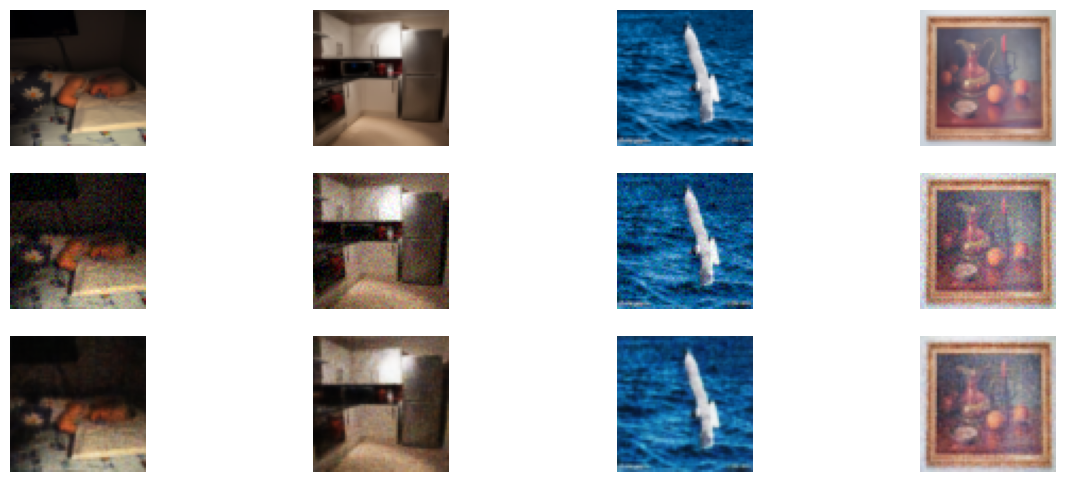

In [22]:
# Visualize results
visualize_reconstruction(model_5, coco_loader)

More depth, back to Relu + Batch and latvec of 512

In [34]:
import torch.nn as nn
import torch

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=512):  # Large latent size
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(256 * 4 * 4, latent_dim)  # Latent representation

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 256 * 4 * 4)  # Map back to encoded tensor
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)

        # Latent representation
        latent = self.fc_enc(self.flatten(enc4))

        # Decoder
        dec = self.fc_dec(latent).view(-1, 256, 4, 4)
        dec = self.decoder1(dec)
        dec = self.decoder2(dec + enc3)  # Skip connection
        dec = self.decoder3(dec + enc2)  # Skip connection
        dec = self.decoder4(dec + enc1)  # Skip connection
        return dec, latent


In [25]:
import torch
from torchvision import models

class PerceptualLoss(nn.Module):
    def __init__(self, pretrained_model=models.vgg16(pretrained=True)):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = nn.Sequential(*list(pretrained_model.features[:16]))  # Use first few layers
        for param in self.feature_extractor.parameters():
            param.requires_grad = False  # Freeze VGG weights

    def forward(self, output, target):
        output_features = self.feature_extractor(output)
        target_features = self.feature_extractor(target)
        loss = torch.nn.functional.mse_loss(output_features, target_features)
        return loss


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 67.6MB/s]


In [35]:
def train_model(model, dataloader, perceptual_loss_fn, epochs=50):
    model.train()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for images in dataloader:
            images = images.to(device)

            # Add noise (optional, for denoising autoencoder)
            noise = torch.randn_like(images) * 0.1
            noisy_images = torch.clamp(images + noise, 0, 1)

            optimizer.zero_grad()

            # Forward pass
            outputs, _ = model(noisy_images)
            loss_mse = mse_loss(outputs, images)  # Reconstruction loss
            loss_perceptual = perceptual_loss_fn(outputs, images)  # Perceptual loss
            loss = loss_mse + 0.1 * loss_perceptual  # Weighted combination
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")


In [36]:
# Define the device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_loader= coco_loader
# Initialize the model
model = ConvAutoencoder(latent_dim=512).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define the loss functions
mse_loss = nn.MSELoss()  # Pixel-wise loss
perceptual_loss_fn = PerceptualLoss(pretrained_model=models.vgg16(pretrained=True)).to(device)  # Perceptual loss

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0
    for batch in train_loader:
        images = batch.to(device)  # Move images to device
        noise = torch.randn_like(images) * 0.1
        noisy_images = images + noise
        noisy_images = torch.clamp(noisy_images, -1, 1)

        # Forward pass
        reconstructed, latent = model(noisy_images)

        # Compute losses
        loss_mse = mse_loss(reconstructed, images)  # MSE loss
        loss_perceptual = perceptual_loss_fn(reconstructed, images)  # Perceptual loss
        loss = loss_mse + 0.1 * loss_perceptual  # Combine losses with a weight for perceptual loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Log the average loss for this epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50], Loss: 0.9768
Epoch [2/50], Loss: 0.4248
Epoch [3/50], Loss: 0.3375
Epoch [4/50], Loss: 0.3098
Epoch [5/50], Loss: 0.2967
Epoch [6/50], Loss: 0.2880
Epoch [7/50], Loss: 0.2813
Epoch [8/50], Loss: 0.2773
Epoch [9/50], Loss: 0.2730
Epoch [10/50], Loss: 0.2715
Epoch [11/50], Loss: 0.2691
Epoch [12/50], Loss: 0.2664


KeyboardInterrupt: 

In [37]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def visualize_results(model, dataloader, device, num_images=4):
    model.eval()  # Set the model to evaluation mode
    data_iter = iter(dataloader)
    images = next(data_iter)  # Get a batch of images
    images = images.to(device)  # Move images to the same device as the model


    noise = torch.randn_like(images) * 0.1
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, -1, 1)
    images= noisy_images

    with torch.no_grad():
        reconstructed, _ = model(noisy_images)  # Forward pass to get reconstructions

    # Move tensors to CPU for visualization
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # Denormalize images (assuming [-1, 1] normalization)
    def denormalize(img):
        return (img * 0.5) + 0.5  # Convert back to [0, 1] range

    images = denormalize(images)
    reconstructed = denormalize(reconstructed)

    # Plot the images
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(to_pil_image(images[i]))
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Reconstructed images
        axes[1, i].imshow(to_pil_image(reconstructed[i]))
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")
    plt.show()


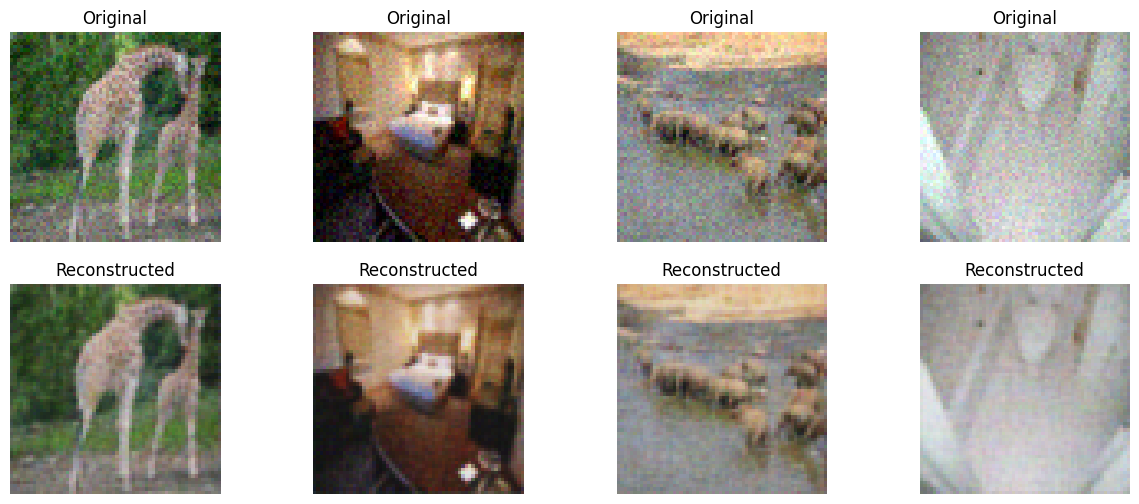

In [38]:
# Visualize results
visualize_results(model, coco_loader, device, num_images=4)


In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.flatten = nn.Flatten()
        self.fc_enc = nn.Linear(128 * 8 * 8, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x, labels=None):  # Add labels argument with default None
        # Encoder with skip connections
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        latent = self.fc_enc(self.flatten(enc3))

        # Decoder with skip connections
        dec = self.fc_dec(latent).view(-1, 128, 8, 8)
        dec = self.decoder1(dec + enc3)
        dec = self.decoder2(dec + enc2)
        dec = self.decoder3(dec + enc1)
        return dec, latent
model = ConvAutoencoder(latent_dim=16).to(device)

In [ ]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        flattened = self.flatten(enc3)

        mu = self.fc_mu(flattened)
        logvar = self.fc_logvar(flattened)
        z = self.reparameterize(mu, logvar)

        dec = self.fc_dec(z).view(-1, 128, 8, 8)
        dec = self.decoder1(dec + enc3)
        dec = self.decoder2(dec + enc2)
        dec = self.decoder3(dec + enc1)
        return dec, mu, logvar


In [ ]:
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (MSE)
    recon_loss = nn.MSELoss()(recon_x, x)

    # KL divergence
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)

    return recon_loss + kld, recon_loss, kld


In [ ]:
def train_vae(model, dataloader, epochs):
    model.train()
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_loss = 0
        total_recon_loss = 0
        total_kld = 0

        for images, _ in dataloader:  # Ignore annotations for the VAE training
            images = images.to(device)
            noisy_images = images + torch.randn_like(images) * 0.1
            noisy_images = torch.clamp(noisy_images, -1, 1)

            optimizer.zero_grad()

            outputs, mu, logvar = model(noisy_images)
            loss, recon_loss, kld = vae_loss_function(outputs, images, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kld += kld.item()

        avg_loss = total_loss / len(dataloader)
        avg_recon_loss = total_recon_loss / len(dataloader)
        avg_kld = total_kld / len(dataloader)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KL Divergence: {avg_kld:.4f}")


In [ ]:
# Autoencoder training
autoencoder = ConvAutoencoder(latent_dim=16).to(device)
train_model(autoencoder, coco_loader, epochs=20)  # Change epochs as needed
# Assuming 'model' is your trained autoencoder
torch.save(autoencoder.state_dict(), 'autoencoder_model.pth')
# VAE training
vae = ConvVAE(latent_dim=16).to(device)
train_vae(vae, coco_loader, epochs=20)
torch.save(vae.state_dict(), 'vae_model.pth')


Epoch [1/20], Loss: 0.11343811947256327
Epoch [2/20], Loss: 0.03547946027293801
Epoch [3/20], Loss: 0.02694669588729739
Epoch [4/20], Loss: 0.024911372335255148
Epoch [5/20], Loss: 0.021225656440481543
Epoch [6/20], Loss: 0.019127099557220934
Epoch [7/20], Loss: 0.01777143818773329
Epoch [8/20], Loss: 0.016601840217784047
Epoch [9/20], Loss: 0.015620655789226294
Epoch [10/20], Loss: 0.015141642845049501
Epoch [11/20], Loss: 0.014172666576877236
Epoch [12/20], Loss: 0.013492254718393087
Epoch [13/20], Loss: 0.012894771129637956
Epoch [14/20], Loss: 0.01268518786393106
Epoch [15/20], Loss: 0.012363463056832552
Epoch [16/20], Loss: 0.012196036644279956
Epoch [17/20], Loss: 0.01166756255850196
Epoch [18/20], Loss: 0.011350702880695462
Epoch [19/20], Loss: 0.011101468215882778
Epoch [20/20], Loss: 0.010633596300706268
Epoch [1/20], Loss: 1.2472, Recon Loss: 0.1437, KL Divergence: 1.1035
Epoch [2/20], Loss: 0.4045, Recon Loss: 0.0541, KL Divergence: 0.3504
Epoch [3/20], Loss: 0.4237, Recon L

In [ ]:
def visualize_vae_reconstruction(model, dataloader, num_images=4):
    model.eval()
    dataiter = iter(dataloader)
    images, _ = next(dataiter)
    images = images[:num_images]
    noisy_images = images + torch.randn_like(images) * 0.1
    noisy_images = torch.clamp(noisy_images, -1, 1)

    with torch.no_grad():
        noisy_images = noisy_images.to(device)
        recon_images, _, _ = model(noisy_images)
        recon_images = recon_images.cpu()

    images = (images * 0.5) + 0.5
    noisy_images = (noisy_images * 0.5) + 0.5
    recon_images = (recon_images * 0.5) + 0.5

    fig, axes = plt.subplots(3, num_images, figsize=(15, 6))
    for i in range(num_images):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(noisy_images[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[2, i].imshow(recon_images[i].permute(1, 2, 0))
        axes[2, i].axis('off')
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Noisy')
    axes[2, 0].set_ylabel('Reconstructed')
    plt.show()


In [ ]:
def evaluate_models(autoencoder, vae, dataloader):
    """
    Evaluate autoencoder and VAE models for image reconstruction using MSE and PSNR.

    Args:
        autoencoder (torch.nn.Module): Trained Autoencoder model.
        vae (torch.nn.Module): Trained VAE model.
        dataloader (torch.utils.data.DataLoader): DataLoader for evaluation dataset.

    Returns:
        dict: Contains averaged MSE and PSNR for both models.
    """
    from sklearn.metrics import mean_squared_error
    import numpy as np

    # Initialize accumulators for metrics
    autoencoder_mse, autoencoder_psnr = 0.0, 0.0
    vae_mse, vae_psnr = 0.0, 0.0
    num_samples = 0

    autoencoder.eval()
    vae.eval()

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(next(autoencoder.parameters()).device)
            num_images = images.size(0)
            num_samples += num_images

            # **Autoencoder Evaluation**
            ae_outputs = autoencoder(images)
            # If model outputs a tuple, select the reconstructed images
            ae_outputs = ae_outputs[0] if isinstance(ae_outputs, tuple) else ae_outputs

            # Compute MSE and PSNR for Autoencoder
            autoencoder_mse += mean_squared_error(
                images.cpu().view(num_images, -1).numpy(),
                ae_outputs.cpu().view(num_images, -1).numpy()
            )
            autoencoder_psnr += psnr(
                images.cpu().numpy(), ae_outputs.cpu().numpy(), data_range=1.0
            )

            # **VAE Evaluation**
            vae_outputs = vae(images)
            # If model outputs a tuple, select the reconstructed images
            vae_outputs = vae_outputs[0] if isinstance(vae_outputs, tuple) else vae_outputs

            # Compute MSE and PSNR for VAE
            vae_mse += mean_squared_error(
                images.cpu().view(num_images, -1).numpy(),
                vae_outputs.cpu().view(num_images, -1).numpy()
            )
            vae_psnr += psnr(
                images.cpu().numpy(), vae_outputs.cpu().numpy(), data_range=1.0
            )

    # Average metrics across samples
    metrics = {
        "Autoencoder MSE": autoencoder_mse / len(dataloader),
        "Autoencoder PSNR": autoencoder_psnr / len(dataloader),
        "VAE MSE": vae_mse / len(dataloader),
        "VAE PSNR": vae_psnr / len(dataloader),
    }

    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return metrics


In [ ]:


# Visualize reconstruction results for the VAE
print("Visualizing VAE reconstruction results...")
visualize_reconstruction(vae_model, coco_loader, num_images=4)

# Evaluate the VAE model
print("Evaluating VAE model...")
evaluate_vae_model(vae_model, coco_loader)

# Compare Autoencoder and VAE metrics
print("Comparing Autoencoder and VAE metrics...")
autoencoder_metrics = evaluate_model(model, coco_loader)  # Assuming model refers to the autoencoder
vae_metrics = evaluate_vae_model(vae_model, coco_loader)

print("Comparison of metrics:")
print("Autoencoder:")
print(autoencoder_metrics)
print("VAE:")
print(vae_metrics)


NameError: name 'VAE' is not defined